In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm 
from PIL import Image

In [3]:
device = "cuda"
batch_size = 256

DATA_PATH = "/home/yhna/SleepEDF_IMG/"
FILE_NAME = "sc_exclude_temp&event_label_O_30mWake_rmMove&?label"
DATASET = "Sleep-EDF-2018"

img_height = 224
img_width = 224

LABEL_NAME = ['Wake', 'N1', 'N2', 'N3', 'REM']

lr_start = 0.0001
lr_min = 0.00005
epochs = 100
num_worker = 8

class SimCLRTransform:
    def __init__(self, size=224):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # 밝기, 대비, 채도, 색조 변화
            ], p=0.8),
            transforms.Lambda(lambda image: image.convert('RGB')),  # RGBA를 RGB로 변환
            transforms.ToTensor(),
        ])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [4]:
class EEGDataLoader(Dataset):

    def __init__(self, transforms, fold, dset_name, dataset_path, file_name, set='train'):

        self.set = set
        self.fold = fold

        self.Hz = 100        
        
        self.dset_name = dset_name
        self.dataset_path = dataset_path
        self.file_name = file_name
        
        self.file_path = self.split_dataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.file_path)

    def __getitem__(self, idx):
        
        
        img_path = self.file_path[idx]
        
        img = Image.open(img_path)
        label_str = img_path[-5]
        
        if label_str == "W": label = 0
        elif label_str == "1": label = 1
        elif label_str == "2": label = 2
        elif label_str == "3": label = 3
        elif label_str == "4": label = 3
        elif label_str == "R": label = 4
            
        if self.transforms is not None:
            img = self.transforms(img)
                    
        return img, label

    
    def split_dataset(self):
        
        file_idx = 0
        inputs, labels, spc, epochs = [], [], [], []
#         data_root = os.path.join(self.dataset_path)
        data_fname_list = os.listdir(os.path.join(self.dataset_path, self.file_name))
        data_fname_dict = {'train': [], 'test': [], 'val': []}
        split_idx_list = np.load(os.path.join(self.dataset_path, 'split_idx', 'idx_{}.npy'.format(self.dset_name)), allow_pickle=True)
    
        if self.dset_name == 'Sleep-EDF-2013':
            for i in range(len(data_fname_list)):
                subject_idx = int(data_fname_list[i][3:5])
                if subject_idx == self.fold - 1:
                    data_fname_dict['test'].append(data_fname_list[i])
                elif subject_idx in split_idx_list[self.fold - 1]:
                    data_fname_dict['val'].append(data_fname_list[i])
                else:
                    data_fname_dict['train'].append(data_fname_list[i])    

        elif self.dset_name == 'Sleep-EDF-2018':
            for i in range(len(data_fname_list)):
                subject_idx = int(data_fname_list[i][3:5])
                if subject_idx in split_idx_list[self.fold - 1][self.set]:
                    data_fname_dict[self.set].append(data_fname_list[i])

        else:
            raise NameError("dataset '{}' cannot be found.".format(self.dataset))
            
        cnt,file_idx = 0, 0
        file_path = []
        for data_fname in tqdm(data_fname_dict[self.set]):
            base_path = os.path.join(self.dataset_path, self.file_name, data_fname)
            img_files = os.listdir(base_path)
            for img in img_files:
                file_path.append(os.path.join(base_path, img))
            
        return file_path
    
fold = 1
train_dataloader_args = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_worker}
valid_dataloader_args = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_worker}
train_dataset = EEGDataLoader(SimCLRTransform(), fold, DATASET, DATA_PATH, FILE_NAME, set='train')
val_dataset = EEGDataLoader(SimCLRTransform(), fold, DATASET, DATA_PATH, FILE_NAME, set='val')
test_dataset = EEGDataLoader(SimCLRTransform(), fold, DATASET, DATA_PATH, FILE_NAME, set='test')

train_loader = DataLoader(dataset=train_dataset, **train_dataloader_args)
val_loader = DataLoader(dataset=val_dataset, **valid_dataloader_args)
test_loader = DataLoader(dataset=test_dataset, **valid_dataloader_args)

100%|██████████| 16/16 [00:00<00:00, 662.94it/s]


In [5]:
# Top Layer 추가: 예를 들어, CIFAR-10의 경우 10개의 클래스가 있습니다.


class SimCLR(nn.Module):
    def __init__(self, base_model, num_classes):
        super(SimCLR, self).__init__()
        self.base_model = base_model(pretrained=False)
        
        # base_model의 마지막 fully connected layer를 제거합니다.
        self.base_model.fc = nn.Identity()
        
        # 분류를 위한 새로운 레이어를 추가합니다.
        self.fc = nn.Linear(512, num_classes)  # ResNet18 기준으로 512는 feature dimension입니다.

    def forward(self, x):
        # base_model을 통해 feature를 추출합니다.
        h = self.base_model(x)
        
        # 추출된 feature를 새로운 분류 레이어로 전달합니다.
        out = self.fc(h)
        
        return out


# model = SimCLR(base_model=models.resnet18, num_classes=10)
# checkpoint = torch.load("./best_model_simCLR_SleepEDF.pth")
# checkpoint = {k:v for k, v in checkpoint.items() if "projection_head" not in k}
# num_classes, num_features = 10, 512
# fc_weights = torch.nn.init.xavier_uniform_(torch.empty(num_classes, num_features))
# fc_bias = torch.zeros(num_classes)

# Add to checkpoint under the correct keys
# checkpoint['fc.weight'] = fc_weights
# checkpoint['fc.bias'] = fc_bias


# model.load_state_dict(checkpoint, strict=True)
# model = nn.DataParallel(model).to(device)

model = models.resnet18(num_classes = 5)
model = nn.DataParallel(model).to(device)

train_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.RandomResizedCrop(size=224),
    transforms.Lambda(lambda image: image.convert('RGB')),  # RGBA를 RGB로 변환
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Lambda(lambda image: image.convert('RGB')),  # RGBA를 RGB로 변환
    transforms.ToTensor(),
])

# Fine-tuning을 위한 데이터셋 준비

train_dataloader_args = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_worker}
valid_dataloader_args = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_worker}
train_dataset = EEGDataLoader(train_transform, fold, DATASET, DATA_PATH, FILE_NAME, set='train')
val_dataset = EEGDataLoader(valid_transform, fold, DATASET, DATA_PATH, FILE_NAME, set='val')
test_dataset = EEGDataLoader(valid_transform, fold, DATASET, DATA_PATH, FILE_NAME, set='test')

train_loader = DataLoader(dataset=train_dataset, **train_dataloader_args)
val_loader = DataLoader(dataset=val_dataset, **valid_dataloader_args)
test_loader = DataLoader(dataset=test_dataset, **valid_dataloader_args)


# Optimizer와 Loss Function 설정
optimizer = optim.Adam(model.parameters(), lr=1e-4) # 보통 fine-tuning은 낮은 학습률을 사용합니다.
criterion = nn.CrossEntropyLoss() # 분류 작업을 위한 Cross Entropy Loss


def fine_tune(model, train_loader, val_loader, criterion, optimizer, epochs=100, device='cuda'):
    model.to(device)
    best_acc = 0
    patience = 5
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        
        
        # Early stopping logic
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.module.state_dict(), 'best_model_finetune_SleepEDF.pth')
            early_stopping_counter = 0
            print(f"Early Stopping Count: {early_stopping_counter}")
        else:
            early_stopping_counter += 1
            print(f"Early Stopping Count: {early_stopping_counter}")
            if early_stopping_counter >= patience:
                print("Early stopping")
                break

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

print("================ Fine-tuning START ================")
# Assuming `fine_tune_loader` is your training loader and `val_loader` is your validation loader
fine_tune(model, train_loader, val_loader, criterion, optimizer, device=device)
print("================ Checking-TEST START ================")
fine_tune(model, val_loader, test_loader, criterion, optimizer, device=device, epochs = 1)

100%|██████████| 16/16 [00:00<00:00, 697.28it/s]


================ Fine-tuning START ================


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 0
Epoch 1, Train Loss: 0.8498, Train Accuracy: 0.6731, Val Loss: 0.8213, Val Accuracy: 0.6861


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 0
Epoch 2, Train Loss: 0.7548, Train Accuracy: 0.7103, Val Loss: 0.8612, Val Accuracy: 0.6937


100%|██████████| 59/59 [00:57<00:00,  1.02it/s]


Early Stopping Count: 0
Epoch 3, Train Loss: 0.7298, Train Accuracy: 0.7192, Val Loss: 0.7267, Val Accuracy: 0.7214


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 1
Epoch 4, Train Loss: 0.7098, Train Accuracy: 0.7248, Val Loss: 0.9367, Val Accuracy: 0.6451


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 0
Epoch 5, Train Loss: 0.6923, Train Accuracy: 0.7327, Val Loss: 0.6967, Val Accuracy: 0.7249


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 1
Epoch 6, Train Loss: 0.6780, Train Accuracy: 0.7369, Val Loss: 0.7278, Val Accuracy: 0.7213


100%|██████████| 59/59 [00:58<00:00,  1.02it/s]


Early Stopping Count: 2
Epoch 7, Train Loss: 0.6720, Train Accuracy: 0.7388, Val Loss: 0.7622, Val Accuracy: 0.7028


100%|██████████| 59/59 [00:57<00:00,  1.02it/s]


Early Stopping Count: 3
Epoch 8, Train Loss: 0.6651, Train Accuracy: 0.7417, Val Loss: 0.7055, Val Accuracy: 0.7211


100%|██████████| 59/59 [00:58<00:00,  1.02it/s]


Early Stopping Count: 0
Epoch 9, Train Loss: 0.6563, Train Accuracy: 0.7459, Val Loss: 0.6891, Val Accuracy: 0.7350


100%|██████████| 59/59 [00:58<00:00,  1.00it/s]


Early Stopping Count: 1
Epoch 10, Train Loss: 0.6485, Train Accuracy: 0.7480, Val Loss: 0.6939, Val Accuracy: 0.7252


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 0
Epoch 11, Train Loss: 0.6443, Train Accuracy: 0.7493, Val Loss: 0.6615, Val Accuracy: 0.7404


100%|██████████| 59/59 [00:57<00:00,  1.02it/s]


Early Stopping Count: 1
Epoch 12, Train Loss: 0.6387, Train Accuracy: 0.7516, Val Loss: 0.6657, Val Accuracy: 0.7365


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 2
Epoch 13, Train Loss: 0.6334, Train Accuracy: 0.7544, Val Loss: 0.7421, Val Accuracy: 0.6998


100%|██████████| 59/59 [00:58<00:00,  1.02it/s]


Early Stopping Count: 3
Epoch 14, Train Loss: 0.6279, Train Accuracy: 0.7547, Val Loss: 0.6675, Val Accuracy: 0.7351


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Early Stopping Count: 4
Epoch 15, Train Loss: 0.6246, Train Accuracy: 0.7560, Val Loss: 0.7630, Val Accuracy: 0.7056


100%|██████████| 59/59 [00:57<00:00,  1.03it/s]


Early Stopping Count: 5
Early stopping
================ Checking-TEST START ================


100%|██████████| 65/65 [01:03<00:00,  1.03it/s]


Early Stopping Count: 0
Epoch 1, Train Loss: 0.6519, Train Accuracy: 0.7471, Val Loss: 0.8134, Val Accuracy: 0.7429


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

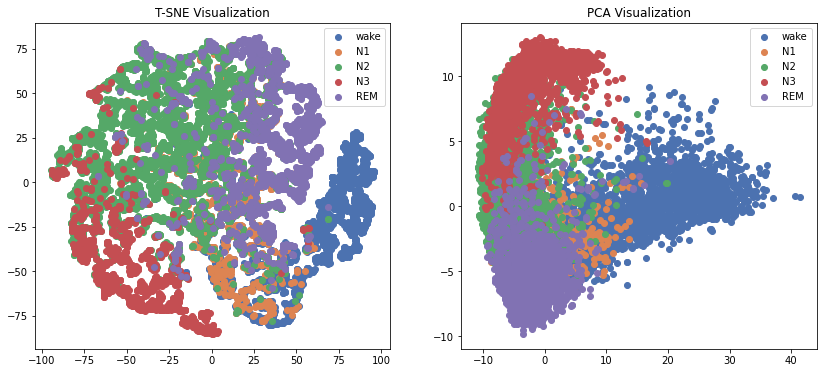

In [17]:
# 특징과 라벨을 추출하는 함수
import seaborn as sns

def extract_features_and_labels(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for x_i, label in loader:
            x_i = x_i.to(device)
            feature = model(x_i).cpu().numpy()
            features.append(feature)
            labels.append(label.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# 시각화 코드는 라벨에 따라 색상을 다르게 할 수 있도록 수정됩니다.
features, labels = extract_features_and_labels(model, val_loader)
tsne_features = TSNE(n_components=2).fit_transform(features)
pca_features = PCA(n_components=2).fit_transform(features)

# 클래스별로 다른 색상을 사용하기 위해 unique labels과 colormap을 준비합니다.
unique_labels = np.unique(labels)
# colors = plt.cm.get_cmap('tab10', len(unique_labels))
palette = sns.color_palette('deep', len(unique_labels))
colors = sns.color_palette(palette)

stage_labels = ['wake', 'N1', 'N2', 'N3', 'REM']

plt.figure(figsize=(14, 6))

# T-SNE 시각화
plt.subplot(1, 2, 1)
for i, label in enumerate(unique_labels):
    plt.scatter(tsne_features[labels == label, 0], tsne_features[labels == label, 1], 
                c=colors[i], label=stage_labels[i])  # 수정된 부분: colors(i) -> colors[i]
plt.title('T-SNE Visualization')
plt.legend()

# PCA 시각화
plt.subplot(1, 2, 2)
for i, label in enumerate(unique_labels):
    plt.scatter(pca_features[labels == label, 0], pca_features[labels == label, 1], 
                c=colors[i], label=stage_labels[i])  # 수정된 부분: colors(i) -> colors[i]
plt.title('PCA Visualization')
plt.legend()

plt.show()